# CycleGAN Horse2Zebra

This notebook is for implementing `Unsupervised-Attention-guided-Image-to-Image-Translation` from the paper [Unsupervised Attention-guided Image-to-Image Traslation](https://arxiv.org/abs/1806.02311) with [Tensorflow](https://www.tensorflow.org). <br>
[Horse2Zebra dataset](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/), which is 256x256 size, will be used. 

Reference: [AlamiMejjati's Github](https://github.com/AlamiMejjati/Unsupervised-Attention-guided-Image-to-Image-Translation)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 
import datetime
import os

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters


In [3]:
algorithm = 'AGGAN'

img_size   = 256
batch_size = 1
num_epoch  = 200

beta1 = 0.5


start_attention_epoch = 30  # When stop the training of attention network
attention_th = 0.1 # Mask selection threshold


init_lr = 0.0002
start_decay_epoch = 100

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./../saved_models/" + date_time + "_" + algorithm

## Import Horse2Zebra Dataset

Get names of the files in the Horse2Zebra dataset folder.

In [4]:
x_list_train = glob.glob('~/Dataset/CycleGAN/horse2zebra/trainA/*.jpg')
x_list_test  = glob.glob('~/Dataset/CycleGAN/horse2zebra/testA/*.jpg')

y_list_train = glob.glob('~/Dataset/CycleGAN/horse2zebra/trainB/*.jpg')
y_list_test = glob.glob('~/Dataset/CycleGAN/horse2zebra/testB/*.jpg')

print("X Train dataset Length: {}".format(len(x_list_train)))
print("X Test dataset Length: {}".format(len(x_list_test)))
print("Y Train dataset Length: {}".format(len(y_list_train)))
print("Y Test dataset Length: {}".format(len(y_list_test)))

X Train dataset Length: 1000
X Test dataset Length: 120
Y Train dataset Length: 1000
Y Test dataset Length: 140


## Attention Network

In [5]:
# Attention network for extracting Mask
def Attention(x, network_name, is_training, reuse=False):
    with tf.variable_scope(network_name,reuse=reuse):
        
        a1 = tf.layers.conv2d(x, filters=32, kernel_size=7, strides=1, padding='SAME')
        a1 = tf.contrib.layers.instance_norm(a1)
        a1 = tf.nn.relu(a1)
        
        a2 = tf.layers.conv2d(a1, filters=64, kernel_size=3, strides=2, padding='SAME')
        a2 = tf.contrib.layers.instance_norm(a2)
        a2 = tf.nn.relu(a2)
        
        r1 = ResNet(a2, is_training, 'resnet1', 64)
        
        up1 = tf.image.resize_nearest_neighbor(r1,[128,128])
        up1 = tf.contrib.layers.instance_norm(up1)
        
        a3 = tf.layers.conv2d(up1, filters=64, kernel_size=3, strides=1, padding='SAME')
        a3 = tf.contrib.layers.instance_norm(a3)
        a3 = tf.nn.relu(a3)
        
        up2 = tf.image.resize_nearest_neighbor(a3,[256,256])
        up2 = tf.contrib.layers.instance_norm(up2)
        
        a4 = tf.layers.conv2d(up2, filters=32, kernel_size=3, strides=1, padding='SAME')
        a4 = tf.contrib.layers.instance_norm(a4)
        a4 = tf.nn.relu(a4)
        
        output = tf.sigmoid(tf.layers.conv2d(a4, filters=1, kernel_size=7, strides=1, padding='SAME')) 
        
        return output

## Generator

In [6]:
def ResNet(x, is_training,  network_name, num_filter):
        
    h = tf.layers.conv2d(x, filters=num_filter, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
    h = tf.contrib.layers.instance_norm(h)
    h = tf.nn.relu(h)
    h = tf.layers.conv2d(h, filters=num_filter, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
    h = tf.contrib.layers.instance_norm(h)
    h = x + h 
    h = tf.nn.relu(h)
    
    return h



def Generator(x, network_name, is_training, reuse=False):
    with tf.variable_scope(network_name, reuse=reuse):
        
        # First Conv (c7s1-32)
        e1 = tf.layers.conv2d(x, filters=32, kernel_size=7, strides=1, padding='SAME')
        e1 = tf.contrib.layers.instance_norm(e1)
        e1 = tf.nn.relu(e1)
        
        # Second Conv (d64)
        e2 = tf.layers.conv2d(e1, filters=64, kernel_size=3, strides=2, padding='SAME')
        e2 = tf.contrib.layers.instance_norm(e2)
        e2 = tf.nn.relu(e2)

        # Third Conv (d128)
        e3 = tf.layers.conv2d(e2, filters=128, kernel_size=3, strides=2, padding='SAME')
        e3 = tf.contrib.layers.instance_norm(e3)
        e3 = tf.nn.relu(e3)

        
        # ResNet Blocks (R128)
        r1 = ResNet(e3, is_training, 'resnet1', 128)
        r2 = ResNet(r1, is_training, 'resnet2', 128)
        r3 = ResNet(r2, is_training, 'resnet3', 128)
        r4 = ResNet(r3, is_training, 'resnet4', 128)
        r5 = ResNet(r4, is_training, 'resnet5', 128)
        r6 = ResNet(r5, is_training, 'resnet6', 128)
        r7 = ResNet(r6, is_training, 'resnet7', 128)
        r8 = ResNet(r7, is_training, 'resnet8', 128)
        r9 = ResNet(r8, is_training, 'resnet9', 128)

        # FIrst Deconv Layer (u64)
        d1 = tf.layers.conv2d_transpose(r9,filters=64, kernel_size=3, strides=2, padding='SAME')
        d1 = tf.contrib.layers.instance_norm(d1)
        d1 = tf.nn.relu(d1)

        d2 = tf.layers.conv2d_transpose(d1,filters=32, kernel_size=3, strides=2, padding='SAME')
        d2 = tf.contrib.layers.instance_norm(d2)
        d2 = tf.nn.relu(d2)

        # Last Conv (c7s1-3)       
        output = tf.tanh(tf.layers.conv2d(d2, filters=3, kernel_size=3, strides=1, padding='SAME')) 
        
        return output

## Discriminator

In [7]:
def Discriminator(x, network_name, is_training, training_flag, reuse=False):
    with tf.variable_scope(network_name, reuse=reuse):


        # First conv layer (C64)
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='SAME')
        h1 = tf.cond(training_flag>0, lambda:tf.contrib.layers.instance_norm(h1) ,lambda:h1)
        h1 = tf.nn.leaky_relu(h1)

        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=4, strides=2, padding='SAME')
        h2 = tf.cond(training_flag>0, lambda:tf.contrib.layers.instance_norm(h2) ,lambda:h2)
        h2 = tf.nn.leaky_relu(h2)

        # Third conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=4, strides=2, padding='SAME')
        h3 = tf.cond(training_flag>0, lambda:tf.contrib.layers.instance_norm(h3) ,lambda:h3)
        h3 = tf.nn.leaky_relu(h3)

        # Fourth conv layer
        h4 = tf.layers.conv2d(h3, filters=512, kernel_size=4, strides=1, padding='SAME')
        h4 = tf.cond(training_flag>0, lambda:tf.contrib.layers.instance_norm(h4) ,lambda:h4)
        h4 = tf.nn.leaky_relu(h4)

        # Output layer  
        logit  = tf.layers.conv2d(h4, filters=1, kernel_size=4, strides=1, padding='SAME')
        output = tf.sigmoid(logit)
       
        
        return logit, output

## GAN

In [9]:
def GAN(x, y, is_training, training_flag):
    
    #################
    ### Generator ###
    #################
    
    # X -> Y
    y_gen = Generator(x, 'Gx', is_training)
    x_mask = Attention(x,'Ax', is_training)
    
    # Y -> X
    x_gen = Generator(y, 'Gy', is_training)
    y_mask = Attention(y,'Ay', is_training)
    
    #generated image_y
    gen_image_y = tf.multiply(tf.concat([x_mask]*3, axis=3), y_gen)+\
                        tf.multiply((1-tf.concat([x_mask]*3,axis=3)),x)

    #generated image_x
    gen_image_x = tf.multiply(tf.concat([y_mask]*3, axis=3), x_gen)+\
                        tf.multiply((1-tf.concat([y_mask]*3,axis=3)),y)
    
    #############
    ### Cycle ###
    #############
    
    # X->Y
    y_cycle = Generator(gen_image_x, 'Gx', is_training, reuse = True)
    x_mask_cycle = Attention(gen_image_x, 'Ax', is_training, reuse = True)
    
    #Y->X
    x_cycle = Generator(gen_image_y, 'Gy', is_training, reuse = True)
    y_mask_cycle = Attention(gen_image_y, 'Ay', is_training, reuse= True)
    
    # generated image_y
    gen_cycle_image_y = tf.multiply(tf.concat([x_mask_cycle]*3, axis=3), y_cycle)+\
                            tf.multiply((1-tf.concat([x_mask_cycle]*3,axis=3)),gen_image_x)
    
    # generated image_x
    gen_cycle_image_x = tf.multiply(tf.concat([y_mask_cycle]*3, axis=3), x_cycle)+\
                                tf.multiply((1-tf.concat([y_mask_cycle]*3,axis=3)),gen_image_y)
    
    #####################
    ### Discriminator ###
    #####################
    
    #Image for step after attention epoch
    Dx_in = tf.where((tf.concat([x_mask]*3, axis=3))>attention_th, x, tf.zeros_like(x))
    Dy_in = tf.where((tf.concat([y_mask]*3, axis=3))>attention_th, y, tf.zeros_like(y))
    
    
    D_logit_x_real, D_out_x_real = tf.cond(training_flag>0, 
             lambda:Discriminator(x, 'Dx', is_training, training_flag),
             lambda: Discriminator(Dx_in, 'Dx', is_training, training_flag,reuse=True))
    D_logit_y_real, D_out_y_real = tf.cond(training_flag>0, 
             lambda: Discriminator(y, 'Dy', is_training, training_flag), 
             lambda:Discriminator(Dy_in, 'Dy', is_training, training_flag, reuse=True))
    
    fake_image_x = tf.cond(training_flag>0,
             lambda:gen_image_x, 
             lambda:tf.where((tf.concat([y_mask]*3, axis=3))>attention_th, gen_image_x, tf.zeros_like(gen_image_x)))
    
    fake_image_y = tf.cond(training_flag>0,
             lambda:gen_image_y, 
             lambda:tf.where((tf.concat([x_mask]*3, axis=3))>attention_th, gen_image_y, tf.zeros_like(gen_image_y)))
    
    D_logit_x_fake, D_out_x_fake = Discriminator(fake_image_x, 'Dx', is_training, training_flag, reuse=True) 
    D_logit_y_fake, D_out_y_fake = Discriminator(fake_image_y, 'Dy', is_training, training_flag, reuse=True)

    
    # Loss function
    Dx_loss = tf.reduce_mean(tf.square(D_logit_x_real-1)) + tf.reduce_mean(tf.square(D_logit_x_fake))
    Dy_loss = tf.reduce_mean(tf.square(D_logit_y_real-1)) + tf.reduce_mean(tf.square(D_logit_y_fake))
    
    D_loss = Dx_loss + Dy_loss
    
    Gx_loss = tf.reduce_mean(tf.square(D_logit_x_fake-1)) 
    Gy_loss = tf.reduce_mean(tf.square(D_logit_y_fake-1)) 
    
    
    cycle_loss = tf.reduce_mean(tf.abs(gen_cycle_image_x-x)) + tf.reduce_mean(tf.abs(gen_cycle_image_y-y))
    
    G_loss = Gx_loss + Gy_loss + 10*cycle_loss
    
    return gen_image_x, gen_image_y, gen_cycle_image_x, gen_cycle_image_y, D_loss, G_loss, cycle_loss,x_mask, y_mask, x_mask_cycle, y_mask_cycle

## Build Graph

In [10]:
tf.reset_default_graph()

x_ = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
y_ = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])

x_normalize = (tf.cast(x_, tf.float32) - (255.0/2)) / (255.0/2)
y_normalize = (tf.cast(y_, tf.float32) - (255.0/2)) / (255.0/2)

is_training = tf.placeholder(tf.bool)
training_flag = tf.placeholder(tf.int32)

lr = tf.placeholder(tf.float32)

x_gen, y_gen, x_cycle, y_cycle, d_loss, g_loss, c_loss, x_mask_, y_mask_, x_mask_cy, y_mask_cy=\
                                        GAN(x_normalize, y_normalize, is_training,training_flag) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('D')]

trainable_variables_gs = [var for var in trainable_variables 
                          if ((var.name.startswith('G'))|(var.name.startswith('A')))]

trainable_variables_g = [var for var in trainable_variables if var.name.startswith('G')]
    

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(g_loss, var_list=trainable_variables_g)
    train_step_gs = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(g_loss, var_list=trainable_variables_gs)


## Initialization

In [11]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [12]:
Saver = tf.train.Saver()
load_model = True
if load_model == True:
    ## For training
#     Saver.restore(sess, tf.train.latest_checkpoint('./saved_models/'))
    
    ## For Test
    Saver.restore(sess, tf.train.latest_checkpoint('./saved_models/Final_model/'))

INFO:tensorflow:Restoring parameters from ./saved_models/Final_model/20190918-19-36-03_AGGAN_199_0


## Train

In [ ]:
if train_model:
    # Training
    len_x_train = len(x_list_train)
    len_y_train = len(y_list_train)

    len_data = np.minimum(len_x_train, len_y_train)

    count_step = 0 

    image_buffer_x = []
    image_buffer_y = []

    learning_rate = init_lr

    for i in range(0,num_epoch):
        # Shuffle the data 
        np.random.shuffle(x_list_train)
        np.random.shuffle(y_list_train)

        batch_count = 0
        
        if i<start_attention_epoch:
            flag_ = 1
        else:
            flag_ = 0
        
        if i > start_decay_epoch:
            learning_rate -= (init_lr / (num_epoch - start_decay_epoch))
                    
                    
        # Making mini-batch
        for j in range(0, len_data, batch_size): 
            if j + batch_size < len_data:
                data_x_batch = np.zeros([batch_size, img_size, img_size, 3])
                data_y_batch = np.zeros([batch_size, img_size, img_size, 3])

                for k in range(batch_size):
                    img_temp_x = cv2.imread(x_list_train[j + k])
                    data_x_batch[k,:,:,:] = img_temp_x

                    img_temp_y = cv2.imread(y_list_train[j + k])
                    data_y_batch[k,:,:,:] = img_temp_y
            else:
                data_x_batch = np.zeros([len_data - j, img_size, img_size, 3])
                data_y_batch = np.zeros([len_data - j, img_size, img_size, 3])

                for k in range(len_data - j):
                    img_temp_x = cv2.imread(x_list_train[j + k])
                    data_x_batch[k,:,:,:] = img_temp_x

                    img_temp_y = cv2.imread(y_list_train[j + k])
                    data_y_batch[k,:,:,:] = img_temp_y      

            # Run Optimizer!

                
            _, D_loss_train = sess.run([train_step_d, d_loss], 
                                       feed_dict = {x_: data_x_batch, y_: data_y_batch, 
                                                    is_training: True, training_flag:flag_, 
                                                    lr: learning_rate})                  
            if flag_ == 1:
                _, G_loss_train = sess.run([train_step_gs, g_loss], 
                                           feed_dict = {x_: data_x_batch, y_: data_y_batch, 
                                                        is_training: True, training_flag:flag_, 
                                                        lr: learning_rate})            
            else:
                 _, G_loss_train = sess.run([train_step_g, g_loss], 
                                            feed_dict = {x_: data_x_batch, y_: data_y_batch, 
                                                         is_training: True, training_flag:flag_, 
                                                         lr: learning_rate})            
            batch_count += 1
            
            print ("Batch: {}".format(j/len_data), end="\r")
            

            if j%3000==0:


                # Print Progess
                print("Epoch: {} / Learning rate: {:.6f} / D Loss: {:.5f} / G Los: {:.5f}".format(
                    (i+1), learning_rate, D_loss_train, G_loss_train))    

                Saver.save(sess,save_path+'_%s_%s'%(str(i),str(j)))
                # Decay learning rate 
                

                # Show test images 
                img_test_x = cv2.imread(x_list_test[np.random.randint(len(x_list_test))])
                img_test_y = cv2.imread(y_list_test[np.random.randint(len(y_list_test))])

                x_sample, y_sample, x_cycle_sample, y_cycle_sample, x_mask_sample, y_mask_sample, x_mask_cycle, y_mask_cycle =\
                            sess.run([x_gen, y_gen, x_cycle, y_cycle, x_mask_, y_mask_, x_mask_cy, y_mask_cy],
                                             feed_dict = {x_: [img_test_x], y_: [img_test_y],
                                                          is_training: False, training_flag:flag_})
                    
                x_sample = (x_sample + 1.0)/2
                y_sample = (y_sample + 1.0)/2
                x_cycle_sample = (x_cycle_sample + 1.0)/2
                y_cycle_sample = (y_cycle_sample + 1.0)/2

                f, ax = plt.subplots(1,6, figsize=(18,18))

                
                ax[0].imshow(cv2.cvtColor(img_test_x, cv2.COLOR_BGR2RGB))
                ax[0].axis('off')
                ax[0].set_title('Input X')
                
                ax[1].imshow(cv2.cvtColor(y_sample[0], cv2.COLOR_BGR2RGB))
                ax[1].axis('off')
                ax[1].set_title('X -> Y')

                ax[2].imshow(cv2.cvtColor(x_cycle_sample[0], cv2.COLOR_BGR2RGB))
                ax[2].axis('off')
                ax[2].set_title('X -> Y -> X')

                ax[3].imshow(cv2.cvtColor(img_test_y, cv2.COLOR_BGR2RGB))
                ax[3].axis('off')
                ax[3].set_title('Input Y')

                ax[4].imshow(cv2.cvtColor(x_sample[0], cv2.COLOR_BGR2RGB))
                ax[4].axis('off')
                ax[4].set_title('Y -> X')

                ax[5].imshow(cv2.cvtColor(y_cycle_sample[0], cv2.COLOR_BGR2RGB))
                ax[5].axis('off')
                ax[5].set_title('Y -> X -> Y')
                
                plt.show()
                
                f1, ax1 = plt.subplots(1,6, figsize=(18,18))
                x_mask_test = np.reshape(x_mask_sample[0],[256,256])
                x_mask_th = np.where(x_mask_test>0.1, np.ones_like(x_mask_test), np.zeros_like(x_mask_test))
                y_mask_cycle_ = np.reshape(y_mask_cycle[0],[256,256])
                y_mask_cycle_test = np.where(y_mask_cycle_>0.1, np.ones_like(y_mask_cycle_), np.zeros_like(y_mask_cycle_))
                
                ax1[0].imshow(x_mask_test,cmap=plt.get_cmap('gray'))
                ax1[0].axis('off')
                ax1[0].set_title('X Mask')
                
                ax1[1].imshow(x_mask_th,cmap=plt.get_cmap('gray'))
                ax1[1].axis('off')
                ax1[1].set_title('X Mask')
                
                ax1[2].imshow(y_mask_cycle_test,cmap=plt.get_cmap('gray'))
                ax1[2].axis('off')
                ax1[2].set_title('Y Mask')
                
                
                y_mask_test = np.reshape(y_mask_sample[0],[256,256])
                y_mask_th = np.where(y_mask_test>0.1, np.ones_like(y_mask_test), np.zeros_like(y_mask_test))
                x_mask_cycle_ = np.reshape(x_mask_cycle[0],[256,256])
                x_mask_cycle_test = np.where(x_mask_cycle_>0.1, np.ones_like(x_mask_cycle_), np.zeros_like(x_mask_cycle_))
                
                ax1[3].imshow(y_mask_test,cmap=plt.get_cmap('gray'))
                ax1[3].axis('off')
                ax1[3].set_title('Y Mask')
                
                ax1[4].imshow(y_mask_th,cmap=plt.get_cmap('gray'))
                ax1[4].axis('off')
                ax1[4].set_title('Y Mask')
                
                ax1[5].imshow(x_mask_cycle_test,cmap=plt.get_cmap('gray'))
                ax1[5].axis('off')
                ax1[5].set_title('Y Mask')
                
                
                

                plt.show()


## Image Generation (X -> Y -> X)

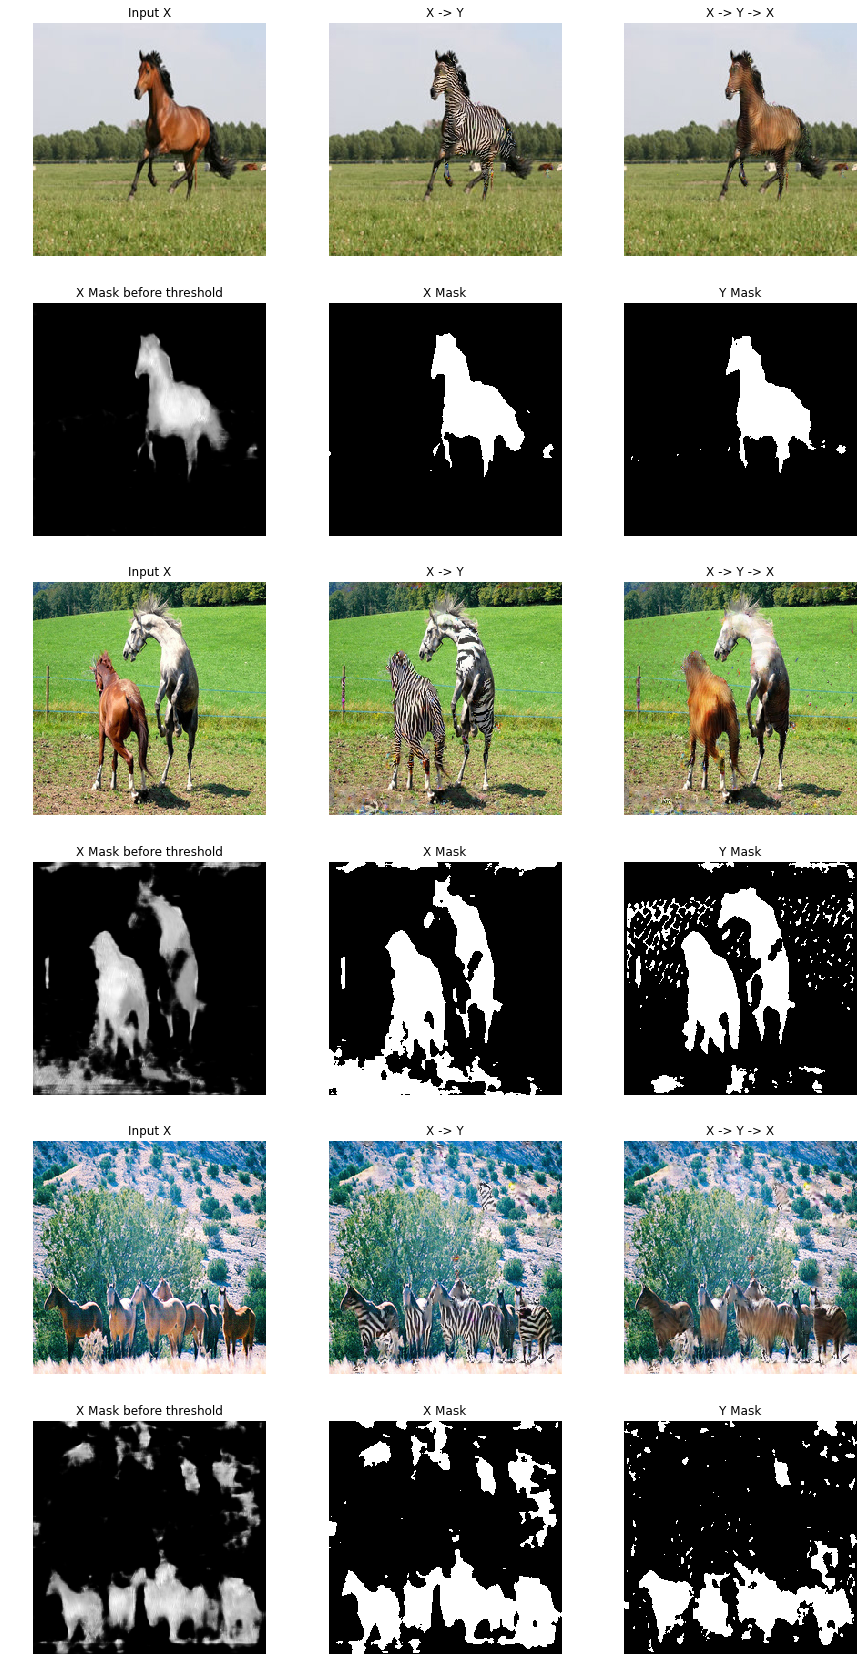

In [20]:
# Show test images 
test_num = 3

f, ax = plt.subplots(test_num*2,3, figsize=(15,30))

test_list = [11, 45, 99]

for i in range(test_num):
    img_test_x = cv2.imread(x_list_test[test_list[i]])

    y_sample, x_cycle_sample, x_mask_sample, y_mask_cycle = sess.run([y_gen, x_cycle, x_mask_, y_mask_cy], 
                                                                  feed_dict = {x_: [img_test_x],                                                                            
                                                                               is_training: False, training_flag:0})

    y_sample = (y_sample + 1.0)/2
    x_cycle_sample = (x_cycle_sample + 1.0)/2


    ax[2*i,0].imshow(cv2.cvtColor(img_test_x, cv2.COLOR_BGR2RGB))
    ax[2*i,0].axis('off')
    ax[2*i,0].set_title('Input X')

    ax[2*i,1].imshow(cv2.cvtColor(y_sample[0], cv2.COLOR_BGR2RGB))
    ax[2*i,1].axis('off')
    ax[2*i,1].set_title('X -> Y')

    ax[2*i,2].imshow(cv2.cvtColor(x_cycle_sample[0], cv2.COLOR_BGR2RGB))
    ax[2*i,2].axis('off')
    ax[2*i,2].set_title('X -> Y -> X')

    x_mask_test = np.reshape(x_mask_sample[0],[256,256])
    x_mask_th = np.where(x_mask_test>0.1, np.ones_like(x_mask_test), np.zeros_like(x_mask_test))
    y_mask_cycle_ = np.reshape(y_mask_cycle[0],[256,256])
    y_mask_cycle_test = np.where(y_mask_cycle_>0.1, np.ones_like(y_mask_cycle_), np.zeros_like(y_mask_cycle_))

    ax[2*i+1,0].imshow(x_mask_test,cmap=plt.get_cmap('gray'))
    ax[2*i+1,0].axis('off')
    ax[2*i+1,0].set_title('X Mask before threshold')

    ax[2*i+1,1].imshow(x_mask_th,cmap=plt.get_cmap('gray'))
    ax[2*i+1,1].axis('off')
    ax[2*i+1,1].set_title('X Mask')

    ax[2*i+1,2].imshow(y_mask_cycle_test,cmap=plt.get_cmap('gray'))
    ax[2*i+1,2].axis('off')
    ax[2*i+1,2].set_title('Y Mask')




## Image Generation (Y -> X -> Y)

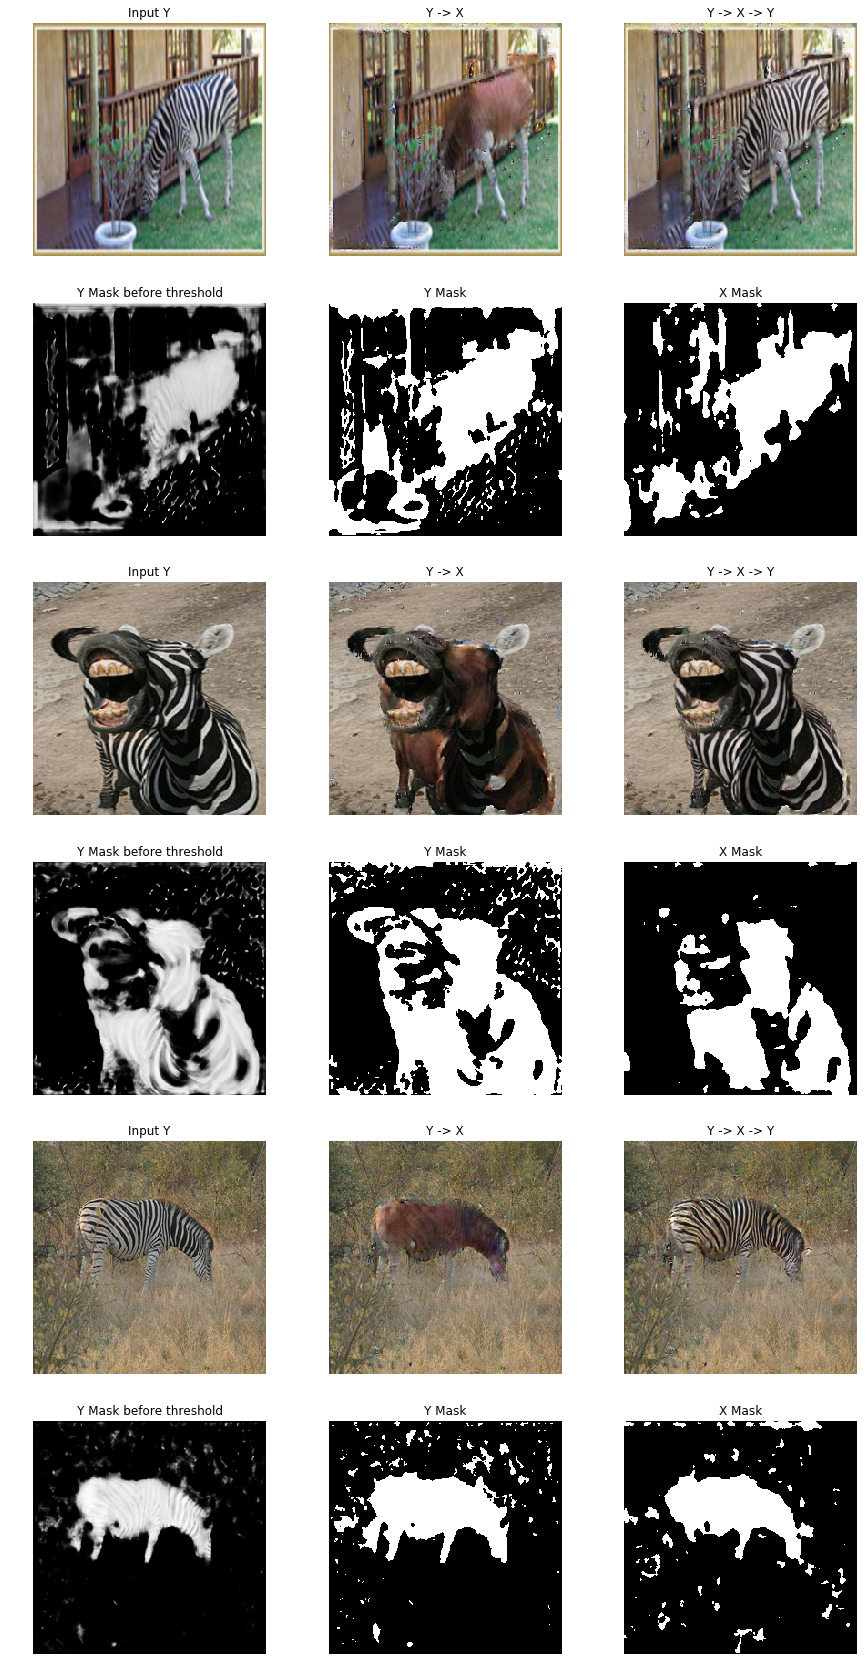

In [38]:
# Show test images 
test_num = 3

f, ax = plt.subplots(test_num*2,3, figsize=(15,30))

test_list = [19, 31, 99]

for i in range(test_num):
    img_test_y = cv2.imread(y_list_test[test_list[i]])

    x_sample, y_cycle_sample,y_mask_sample, x_mask_cycle, = sess.run([x_gen, y_cycle, y_mask_, x_mask_cy], 
                                                                  feed_dict = {y_: [img_test_y],                                                                           y_: [img_test_y], 
                                                                               is_training: False, training_flag:0})
    x_sample = (x_sample + 1.0)/2
    y_cycle_sample = (y_cycle_sample + 1.0)/2


    ax[2*i,0].imshow(cv2.cvtColor(img_test_y, cv2.COLOR_BGR2RGB))
    ax[2*i,0].axis('off')
    ax[2*i,0].set_title('Input Y')

    ax[2*i,1].imshow(cv2.cvtColor(x_sample[0], cv2.COLOR_BGR2RGB))
    ax[2*i,1].axis('off')
    ax[2*i,1].set_title('Y -> X')

    ax[2*i,2].imshow(cv2.cvtColor(y_cycle_sample[0], cv2.COLOR_BGR2RGB))
    ax[2*i,2].axis('off')
    ax[2*i,2].set_title('Y -> X -> Y')


    y_mask_test = np.reshape(y_mask_sample[0],[256,256])
    y_mask_th = np.where(y_mask_test>0.1, np.ones_like(y_mask_test), np.zeros_like(y_mask_test))
    x_mask_cycle_ = np.reshape(x_mask_cycle[0],[256,256])
    x_mask_cycle_test = np.where(x_mask_cycle_>0.1, np.ones_like(x_mask_cycle_), np.zeros_like(x_mask_cycle_))

    ax[2*i+1,0].imshow(y_mask_test,cmap=plt.get_cmap('gray'))
    ax[2*i+1,0].axis('off')
    ax[2*i+1,0].set_title('Y Mask before threshold')

    ax[2*i+1,1].imshow(y_mask_th,cmap=plt.get_cmap('gray'))
    ax[2*i+1,1].axis('off')
    ax[2*i+1,1].set_title('Y Mask')

    ax[2*i+1,2].imshow(x_mask_cycle_test,cmap=plt.get_cmap('gray'))
    ax[2*i+1,2].axis('off')
    ax[2*i+1,2].set_title('X Mask')




## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))